In [1]:
%load_ext autoreload
%autoreload 2

## California dataset

The [dataset](https://energy.duke.edu/content/distributed-solar-pv-array-location-and-extent-data-set-remote-sensing-object-identification) is divided in a training set, a validation set and testing set. To avoid bias, these sets are *always* the same.

In [2]:
import random
import via as VIA

from dataset import VIADataset, ColorJitter, RandomFilter, RandomTranspose, ToTensor

via = VIA.load('../products/json/california.json')

keys = sorted(list(via.keys()))

random.seed(0)
random.shuffle(keys)

train_via = {key: via[key] for key in keys[:350]}
valid_via = {key: via[key] for key in keys[350:400]}

trainset = ToTensor(RandomTranspose(RandomFilter(ColorJitter(VIADataset(train_via, '../resources/california/', shuffle=True)))))
validset = ToTensor(VIADataset(valid_via, '../resources/california/', shuffle=True))

print('Training size = {}'.format(len(trainset)))
print('Validation size = {}'.format(len(validset)))

Training size = 14236
Validation size = 2078


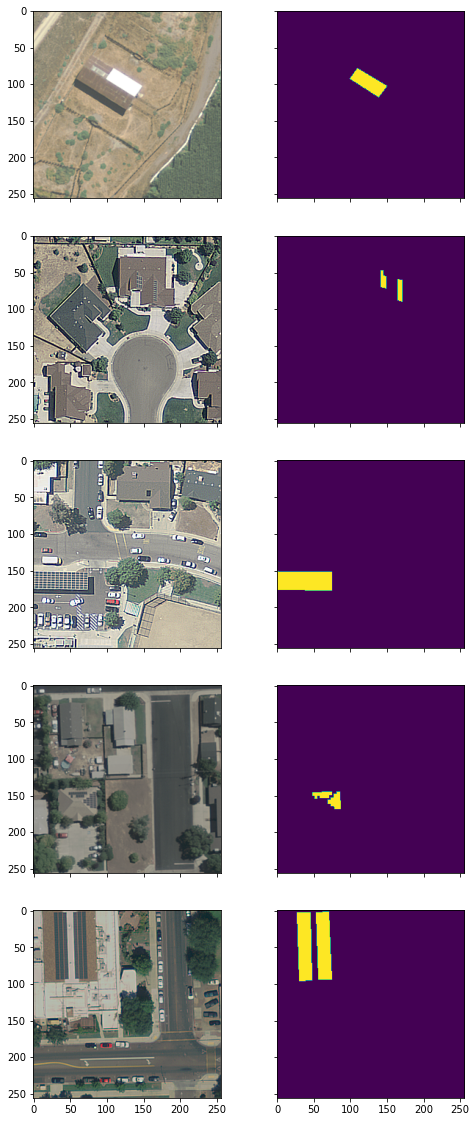

In [3]:
from torch.utils.data import DataLoader
from dataset import to_pil
from plots import plot_alongside

trainloader = DataLoader(trainset, batch_size=5)
validloader = DataLoader(validset, batch_size=5)

for inputs, targets in trainloader:
    break

plot_alongside(
    map(to_pil, inputs),
    map(to_pil, targets)
)

## Model

The model used is **SegNet**, trained for `100` epochs on `trainloader` with the `DiceLoss` loss function.

In [4]:
import torch
from torchsummary import summary
from models import SegNet

model = SegNet(3, 1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

model.load_state_dict(torch.load('../products/models/segnet_100.pth', map_location=device))

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14  [[

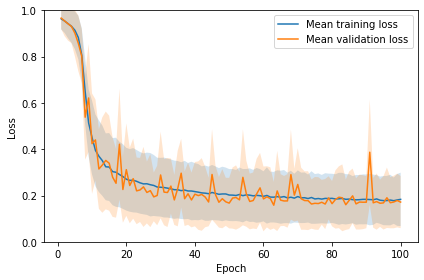

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

stats = pd.read_csv('../products/csv/segnet_statistics.csv')

plt.plot(stats['epoch'], stats['train_loss_mean'], label='Mean training loss')
plt.fill_between(
    stats['epoch'],
    stats['train_loss_mean'] - stats['train_loss_std'],
    stats['train_loss_mean'] + stats['train_loss_std'],
    alpha=0.2
)

plt.plot(stats['epoch'], stats['valid_loss_mean'], label='Mean validation loss')
plt.fill_between(
    stats['epoch'],
    stats['valid_loss_mean'] - stats['valid_loss_std'],
    stats['valid_loss_mean'] + stats['valid_loss_std'],
    alpha=0.2
)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0., 1.)
plt.legend()
plt.tight_layout()
plt.savefig('../products/segnet_mean_loss.pdf', transparent=True)
plt.show()

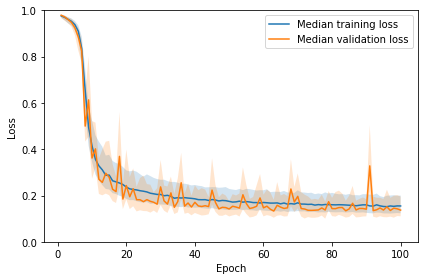

In [6]:
plt.plot(stats['epoch'], stats['train_loss_second'], label='Median training loss')
plt.fill_between(
    stats['epoch'],
    stats['train_loss_first'],
    stats['train_loss_third'],
    alpha=0.2
)

plt.plot(stats['epoch'], stats['valid_loss_second'], label='Median validation loss')
plt.fill_between(
    stats['epoch'],
    stats['valid_loss_first'],
    stats['valid_loss_third'],
    alpha=0.2
)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0., 1.)
plt.legend()
plt.tight_layout()
plt.savefig('../products/segnet_median_loss.pdf', transparent=True)
plt.show()

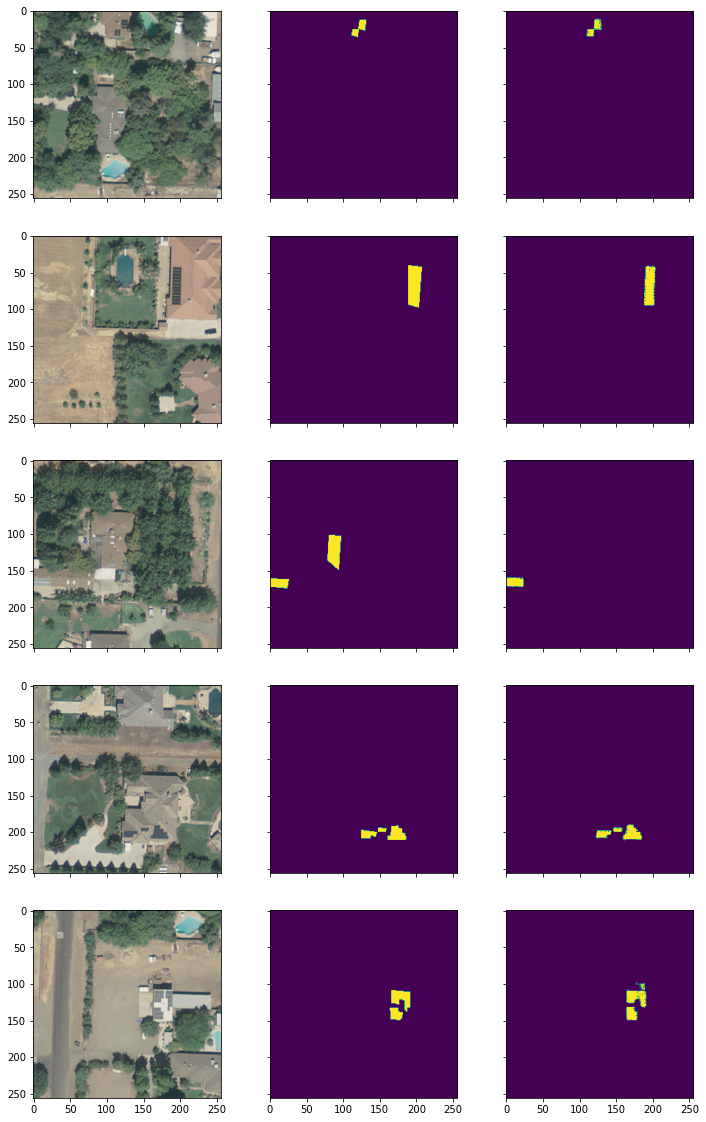

In [7]:
model.eval()

with torch.no_grad():
    for inputs, targets in validloader:
        break

    inputs = inputs.to(device)
    targets = targets.to(device)
    outputs = model(inputs)

plot_alongside(
    map(to_pil, inputs.cpu()),
    map(to_pil, targets.cpu()),
    map(to_pil, outputs.cpu())
)

## Average Precision

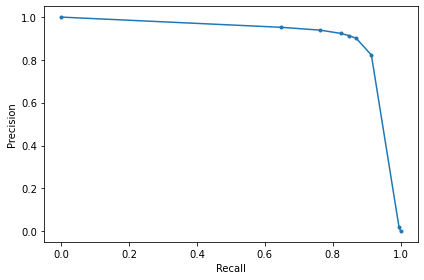

In [8]:
import numpy as np
import train

from criterions import TP, TN, FP, FN

metrics = train.eval(
    model,
    validloader,
    [m(x) for m in [TP, TN, FP, FN] for x in [1e-6, 1e-3, 0.1, 0.5, 0.9, 1 - 1e-3, 1 - 1e-6]]
)

metrics = np.array(metrics).sum(axis=0).reshape((4, -1))

precision = metrics[0] / (metrics[0] + metrics[2])
recall = metrics[0] / (metrics[0] + metrics[3])

precision = np.insert(precision, 0, 0.)
recall = np.insert(recall, 0, 1.)

precision = np.append(precision, 1.)
recall = np.append(recall, 0.)

plt.plot(recall, precision, '.-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.tight_layout()
plt.savefig('../products/segnet_precision_recall.pdf', transparent=True)
plt.show()

In [9]:
average_precision = -np.trapz(x=recall, y=precision)

print('Average precision = {}'.format(average_precision))

Average precision = 0.9121712763728972
